In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [66]:
tf.__version__

'2.15.0'

In [176]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)


train_dataset = tf.keras.utils.image_dataset_from_directory("dataset/skin-lesions/train",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory("dataset/skin-lesions/test",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory("rsults/skin_lesion",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 15004 files belonging to 3 classes.


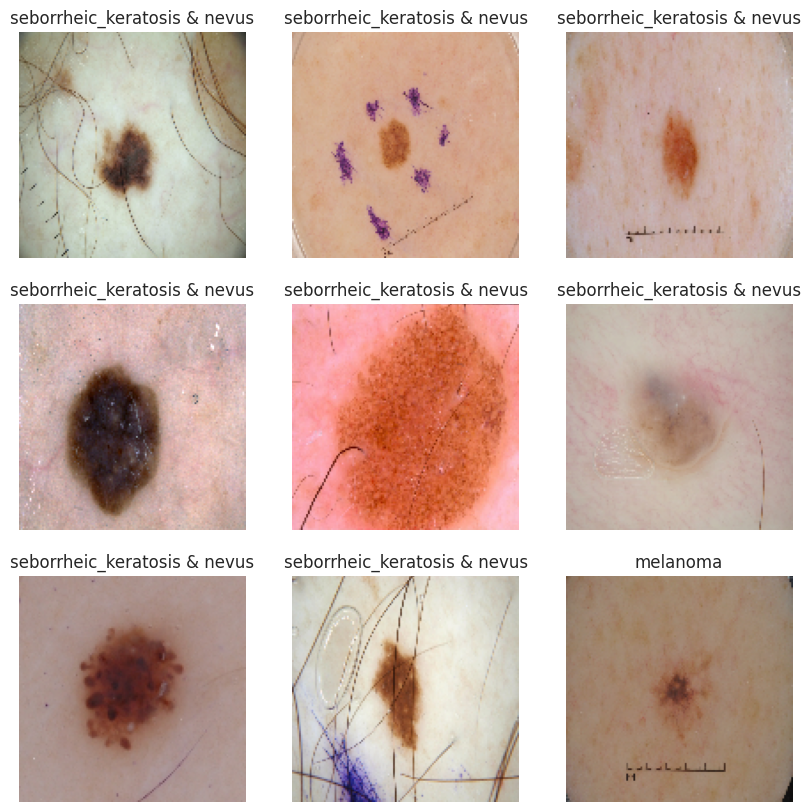

In [177]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [179]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [180]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(),
  # tf.keras.layers.RandomFlip('vertical'),
  # tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomTranslation(0.2, 0.2),
  # tf.keras.layers.RandomBrightness(0.2),
])

In [181]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = True
fine_tune_at = 800

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,"relu")(x)
outputs = tf.keras.layers.Dense(3,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [190]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, 4, 4, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2560)              0         
                                                                 
 flatten_3 (Flatten)         (None, 2560)              0   

In [191]:
# base_learning_rate = 0.001
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history_fine = model.fit(train_dataset,
                         epochs=10,
                         callbacks=callback,
                         validation_data=validation_dataset)


In [143]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # Load the raw image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming the image is in JPEG format. Use decode_image for more general formats.
    
    # Resize the image to the required dimensions
    img = tf.image.resize(img, target_size)
    
    # Normalize the pixel values to [0, 1]
    img = img / 255.0

    return img

def predict_image(model, img_path):
    # Load and preprocess the image
    img = load_and_preprocess_image(img_path)
    
    # Expand dimensions to simulate a batch
    img_batch = tf.expand_dims(img, 0)
    
    # Get predictions
    predictions = model.predict(img_batch)
    
    return predictions

In [146]:
images,labels = train_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
result = predictions.argmax(axis=1)


In [147]:
print('Predictions:\n', result)
print('Labels:\n', labels)

Predictions:
 [0 0 0 1 1 2 2 1 2 2 1 0 0 2 1 0 2 2 0 1 1 2 2 0 0 0 1 2 1 2 0 0]
Labels:
 [0 2 0 0 0 2 2 1 1 2 0 2 0 0 0 0 0 1 2 2 0 1 1 2 1 1 2 1 1 2 1 1]


In [148]:
predictions

array([[9.97035265e-01, 7.26250346e-06, 2.95747933e-03],
       [9.99934673e-01, 1.10071242e-05, 5.43378155e-05],
       [8.11190665e-01, 4.53938774e-05, 1.88763916e-01],
       [1.31658999e-06, 9.99996901e-01, 1.74887521e-06],
       [1.10600183e-06, 9.99998927e-01, 6.04569816e-09],
       [2.84037815e-04, 9.38393714e-05, 9.99622107e-01],
       [1.89334497e-01, 8.74919642e-05, 8.10578048e-01],
       [1.29882887e-04, 9.97201920e-01, 2.66816467e-03],
       [5.47509687e-03, 8.46775249e-04, 9.93678153e-01],
       [1.57347298e-03, 8.22290076e-06, 9.98418331e-01],
       [3.74331295e-01, 6.25665307e-01, 3.35936784e-06],
       [9.99900937e-01, 3.58238576e-05, 6.31887160e-05],
       [9.98508871e-01, 2.48128231e-06, 1.48861972e-03],
       [7.94090913e-04, 4.12443260e-05, 9.99164701e-01],
       [8.50772813e-06, 9.99991536e-01, 8.91606788e-09],
       [9.98978019e-01, 6.62507136e-06, 1.01533148e-03],
       [3.92408147e-02, 2.56837899e-04, 9.60502386e-01],
       [2.67589297e-02, 3.33049

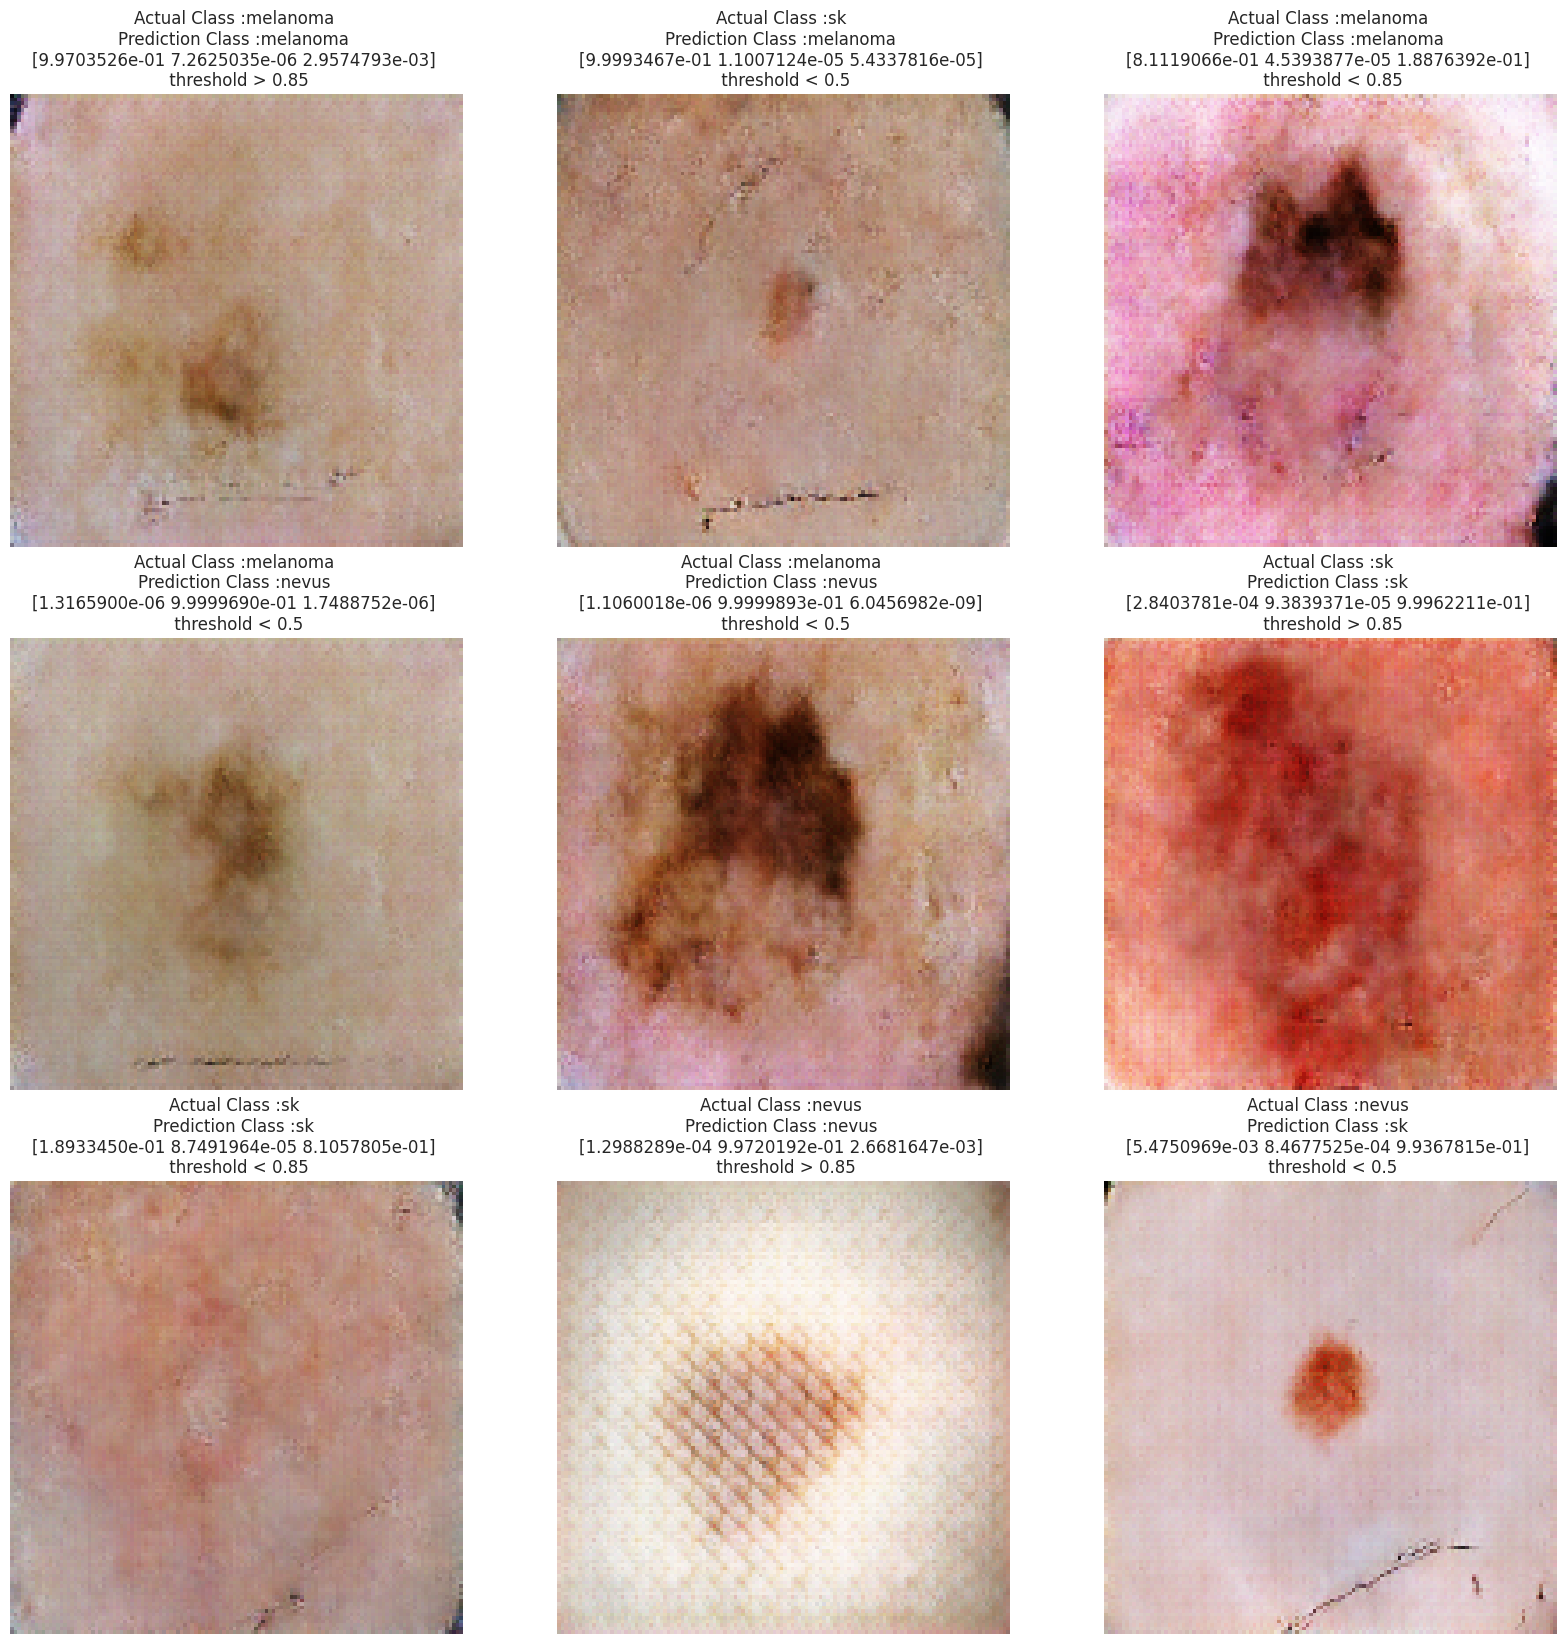

In [149]:
plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    if predictions[i][labels[i]] < 0.5:
        txt = "threshold < 0.5"
    elif predictions[i][labels[i]] >= 0.5 and predictions[i][labels[i]] < 0.75:
        txt = "threshold < 0.75"
    elif predictions[i][labels[i]] >= 0.75 and predictions[i][labels[i]] < 0.85:
        txt = "threshold < 0.85"
    else:
        txt = "threshold > 0.85"
    plt.title(f"Actual Class :{class_names[labels[i]]} \nPrediction Class :{class_names[result[i]]} \n{predictions[i]} \n {txt}")
    plt.axis("off")